# Bank Customer Churn

#### 1. Import Libraries

In [ ]:
# Data Manipulation 
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Preprocessing & Feature Engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model Selection & Validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, precision_score, 
    recall_score, f1_score, roc_curve, roc_auc_score
)
from sklearn.inspection import permutation_importance

# Hyperparameter Distributions
from scipy.stats import randint, uniform

# Imbalanced Data Handling & Pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Use the pipeline from imblearn

print("Libraries Imported")

Libraries Imported


#### 2. Import Data

In [3]:
# Load the Customer and Account data from the Excel file
file_path = 'Bank_Churn_Messy.xlsx'
bank_data = pd.read_excel(file_path, sheet_name=None)

# Load the sheets into separate DataFrames
customer_info = bank_data['Customer_Info']
account_info = bank_data['Account_Info']

bank_data = pd.merge(customer_info, account_info, on='CustomerId', how='left')

print('Data loaded successfully')

Data loaded successfully


#### 3. Data Overview

##### 3.1 Preview Data

In [4]:
bank_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure_x,EstimatedSalary,Balance,NumOfProducts,HasCrCard,Tenure_y,IsActiveMember,Exited
0,15634602,Hargrave,619,FRA,Female,42.0,2,€101348.88,€0.0,1,Yes,2,Yes,1
1,15634602,Hargrave,619,FRA,Female,42.0,2,€101348.88,€0.0,1,Yes,2,Yes,1
2,15647311,Hill,608,Spain,Female,41.0,1,€112542.58,€83807.86,1,Yes,1,Yes,0
3,15619304,Onio,502,French,Female,42.0,8,€113931.57,€159660.8,3,No,8,No,1
4,15701354,Boni,699,FRA,Female,39.0,1,€93826.63,€0.0,2,No,1,No,0


##### 3.2 Data Info

In [5]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10004 non-null  int64  
 1   Surname          10001 non-null  object 
 2   CreditScore      10004 non-null  int64  
 3   Geography        10004 non-null  object 
 4   Gender           10004 non-null  object 
 5   Age              10001 non-null  float64
 6   Tenure_x         10004 non-null  int64  
 7   EstimatedSalary  10004 non-null  object 
 8   Balance          10004 non-null  object 
 9   NumOfProducts    10004 non-null  int64  
 10  HasCrCard        10004 non-null  object 
 11  Tenure_y         10004 non-null  int64  
 12  IsActiveMember   10004 non-null  object 
 13  Exited           10004 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


##### 3.3 Data Description

In [6]:
bank_data.describe()

,CustomerId,CreditScore,Age,Tenure_x,NumOfProducts,Tenure_y,Exited
count,1.000400e+04,10004.000000,10001.000000,10004.000000,10004.000000,10004.000000,10004.000000
mean,1.569092e+07,650.568073,38.919108,5.012195,1.529988,5.012195,0.203719
std,7.193218e+04,96.665531,10.488725,2.891806,0.581635,2.891806,0.402782
min,1.556570e+07,350.000000,18.000000,0.000000,1.000000,0.000000,0.000000
25%,1.562839e+07,584.000000,32.000000,3.000000,1.000000,3.000000,0.000000
50%,1.569071e+07,652.000000,37.000000,5.000000,1.000000,5.000000,0.000000
75%,1.575322e+07,718.000000,44.000000,7.000000,2.000000,7.000000,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,4.000000,10.000000,1.000000


##### 3.4 Missing Values

In [7]:
# Check for missing values
missing_values = bank_data.isnull().sum()
print("Missing Values: ", missing_values)
print("\n")

rows_with_missing_values = bank_data[bank_data.isnull().any(axis=1)]
print(rows_with_missing_values) 

Missing Values:  CustomerId         0
Surname            3
CreditScore        0
Geography          0
Gender             0
Age                3
Tenure_x           0
EstimatedSalary    0
Balance            0
NumOfProducts      0
HasCrCard          0
Tenure_y           0
IsActiveMember     0
Exited             0
dtype: int64


      CustomerId Surname  CreditScore Geography  Gender  Age  Tenure_x  \
29      15728693     NaN          574   Germany  Female  NaN         3   
122     15580203     NaN          674     Spain    Male  NaN         6   
9390    15756954     NaN          538    France  Female  NaN         2   

     EstimatedSalary     Balance  NumOfProducts HasCrCard  Tenure_y  \
29          -€999999  €141349.43              1       Yes         3   
122         -€999999  €120193.42              1        No         6   
9390        -€999999        €0.0              1       Yes         2   

     IsActiveMember  Exited  
29              Yes       0  
122              No       0  
93

#### 4. Data Cleaning

Before building any models, I performed data cleaning to ensure consistency and reliability. This included removing duplicates, filling missing values, and standardizing categorical values (e.g., unifying different representations of "France" in the Geography column). These steps are essential to avoid introducing bias or errors into the model and to ensure that all features are interpreted correctly by machine learning algorithms.

In [8]:
# Drop duplicate rows, keeping the first occurrence by default
bank_data = bank_data.drop_duplicates()

# Fill missing values 
bank_data.fillna({'Age': bank_data['Age'].mean(), 'Surname': 'Missing Value'}, inplace=True)

#fix data types
bank_data['EstimatedSalary'] = bank_data['EstimatedSalary'].str.replace('€', '').astype(float)
bank_data['Balance'] = bank_data['Balance'].str.replace('€', '').astype(float)
bank_data['Age'] = bank_data['Age'].astype(int)


# Replace Estimated Salary anomoly with the mean of the column
bank_data['EstimatedSalary'] = bank_data['EstimatedSalary'].replace(-999999.0, bank_data['EstimatedSalary'].mean())

# Stanardize Geography values
bank_data['Geography'] = np.where(bank_data['Geography'].isin(['FRA', 'French', 'France']), 'France', bank_data['Geography'])

#drop and rename columns
bank_data = bank_data.drop(columns=['Tenure_y'])
bank_data = bank_data.rename(columns={'Tenure_x': 'Tenure'})  

#### 5. Data Exploration 

I visualized churn rates by age, generation, credit score, and other features to identify patterns and potential drivers of churn. For example, plotting churn by generation or credit score category helps reveal which customer segments are most at risk, guiding both feature engineering and business strategy.

##### 5.1 Churn Overview

Total Customers: 10000
Customers Churned: 2037
Churn Rate: 20.37%


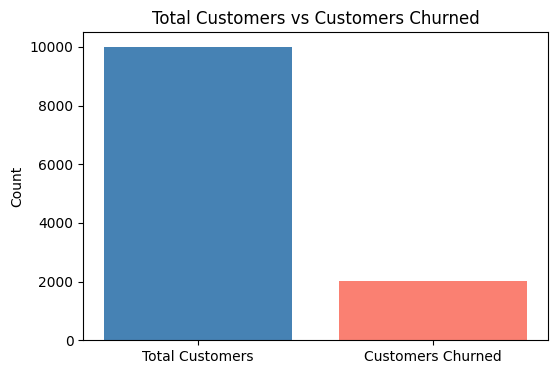

In [9]:
total_customers = bank_data.shape[0]
print(f"Total Customers: {total_customers}")

customers_churned = bank_data[bank_data['Exited'] == 1].shape[0]
print(f"Customers Churned: {customers_churned}")

churn_rate = (customers_churned / total_customers) * 100
print(f"Churn Rate: {churn_rate:.2f}%")

# Total Customers and Customers Churned
labels = ['Total Customers', 'Customers Churned']
values = [total_customers, customers_churned]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['steelblue', 'salmon'])
plt.title('Total Customers vs Customers Churned')
plt.ylabel('Count')
plt.show()

##### 5.2 Churn by Age

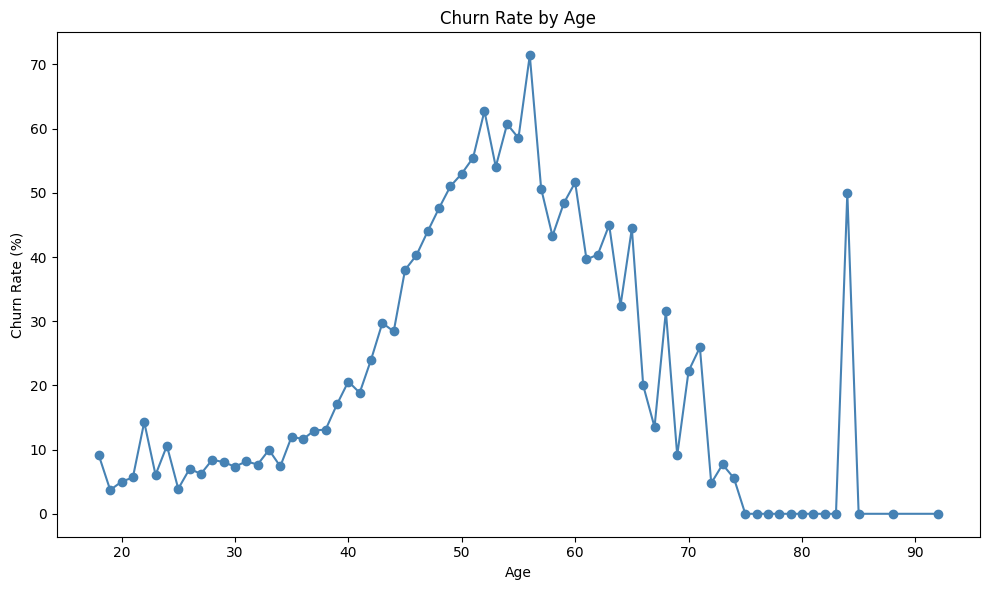

In [10]:
# Calculate churn rate by age
churn_by_age = bank_data.groupby('Age')['Exited'].mean() * 100

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(churn_by_age.index, churn_by_age.values, marker='o', color='steelblue', label='Churn Rate')
plt.title('Churn Rate by Age')
plt.xlabel('Age')
plt.ylabel('Churn Rate (%)')
plt.tight_layout()
plt.show()

##### 5.3 Churn by Generation

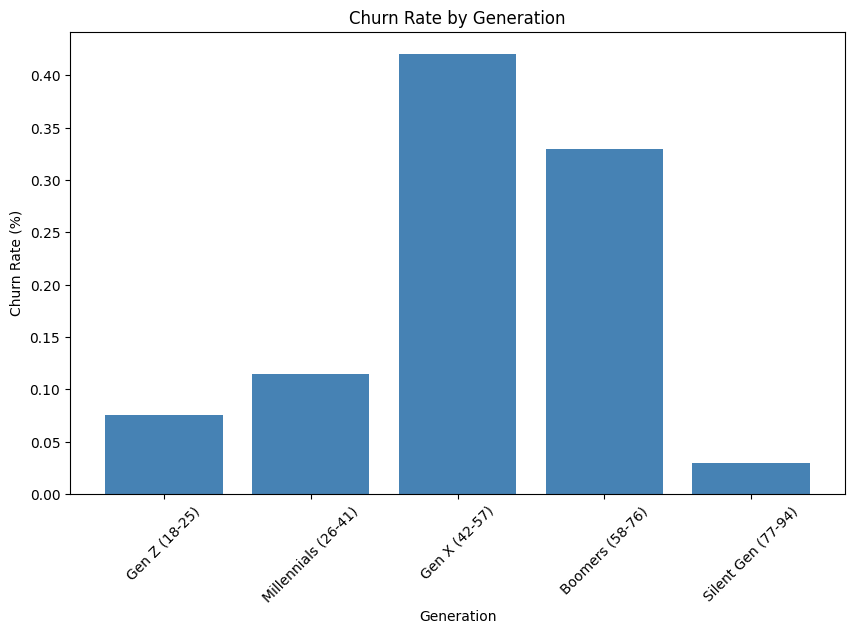

In [11]:
# Define bins and labels for generations
bins = [18, 26, 42, 58, 77, 95]  # Age ranges for generations
labels = ['Gen Z (18-25)', 'Millennials (26-41)', 'Gen X (42-57)', 'Boomers (58-76)', 'Silent Gen (77-94)']

# Bin ages into generations
bank_data['Age_Group'] = pd.cut(bank_data['Age'], bins=bins, labels=labels, right=False)

# Calculate churn rate by generation
age_churn_rate = bank_data.groupby('Age_Group', observed=True)['Exited'].mean().to_dict()   

# Plot the churn rate by generation
plt.figure(figsize=(10, 6))
plt.bar(age_churn_rate.keys(), age_churn_rate.values(), color='steelblue')
plt.title('Churn Rate by Generation')
plt.xlabel('Generation')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

##### 5.4 Churn by Credit Score

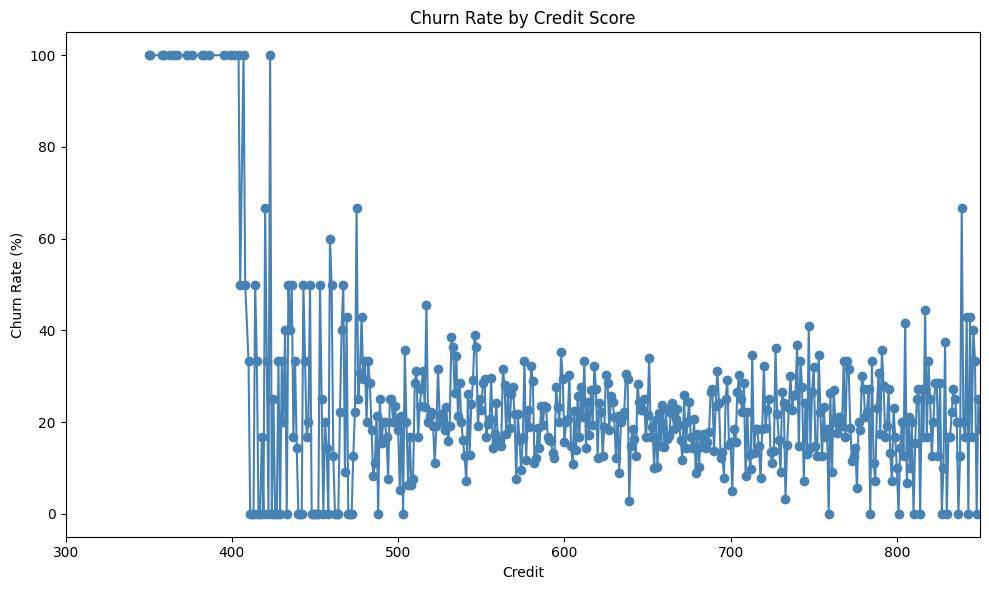

In [12]:
# Calculate churn rate by age
churn_by_credit = bank_data.groupby('CreditScore')['Exited'].mean() * 100

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(churn_by_credit.index, churn_by_credit.values, marker='o', color='steelblue', label='Churn Rate')
plt.title('Churn Rate by Credit Score')
plt.xlabel('Credit')
plt.ylabel('Churn Rate (%)')
plt.xlim(300, 850) # Set x-axis limits to match credit score range
plt.tight_layout()
plt.show()

##### 5.5 Churn by Credit Score Category

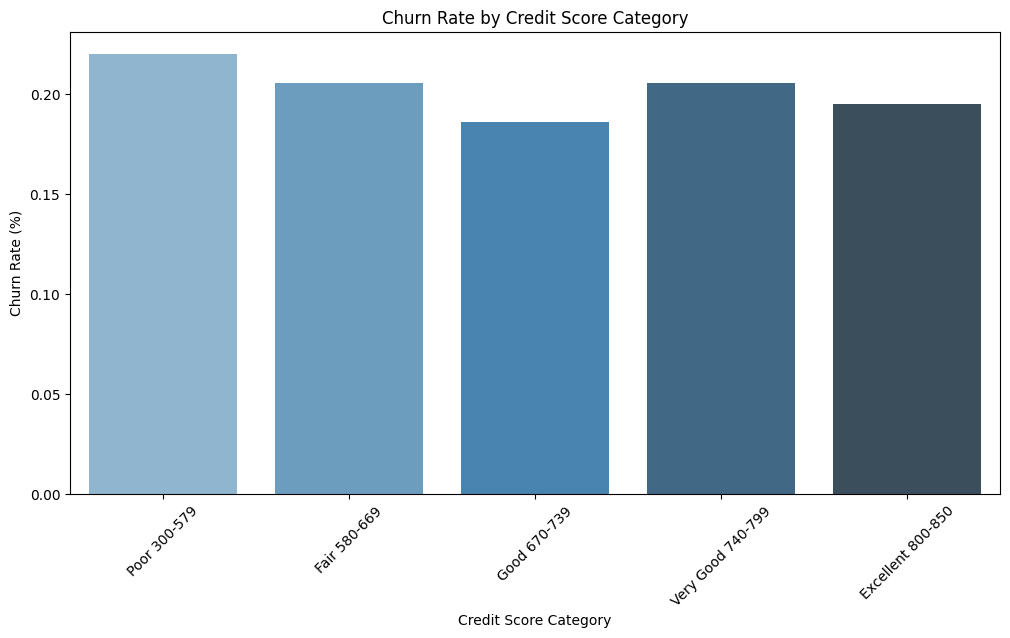

In [13]:
#  Bin the credit scores into categories
bins = [300, 579, 669, 739, 799, 850]  # Define the bin edges
labels = ['Poor 300-579', 'Fair 580-669', 'Good 670-739', 'Very Good 740-799', 'Excellent 800-850']  # Define the labels for the bins

# Create a new column for credit score categories
bank_data['Credit_Score_Category'] = pd.cut(bank_data['CreditScore'], bins=bins, labels=labels, include_lowest=True)

# Example visualization of churn rate by credit score category
plt.figure(figsize=(12, 6))
sns.barplot(data=bank_data, x='Credit_Score_Category', y='Exited', hue='Credit_Score_Category', errorbar=None, palette='Blues_d')
plt.title('Churn Rate by Credit Score Category')
plt.xlabel('Credit Score Category')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()

##### 5.6 Churn by Categorical Features

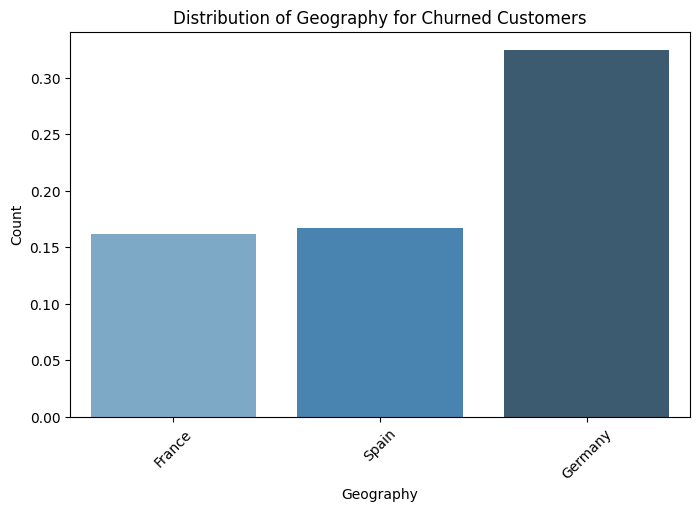

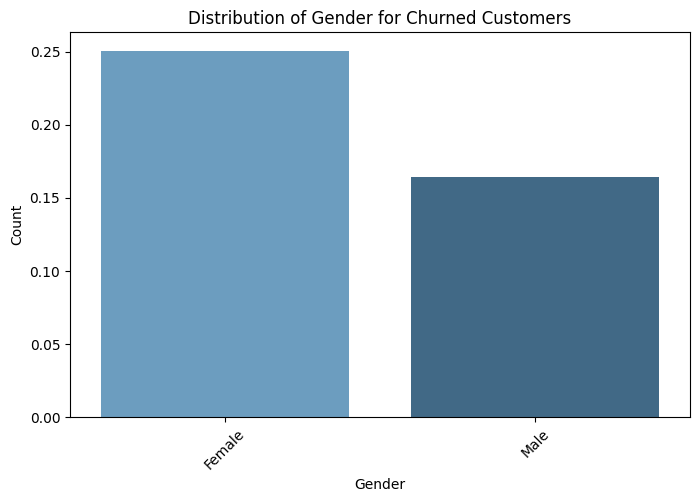

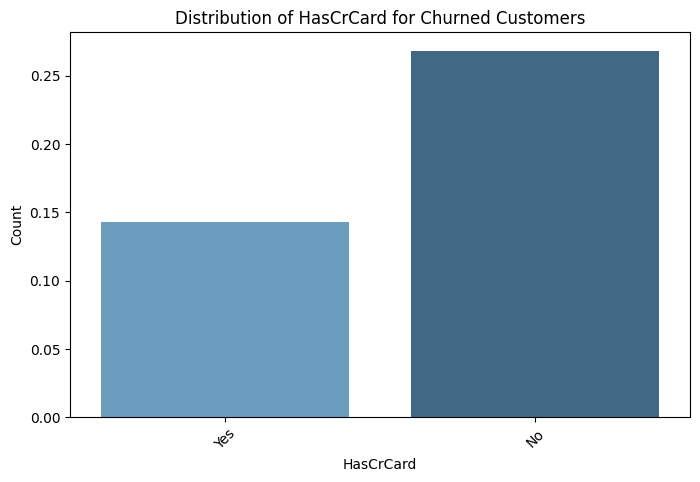

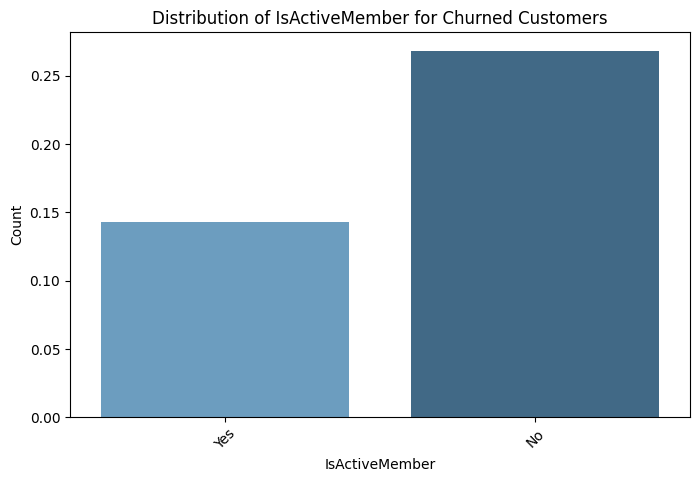

In [14]:
# Generate plots for object dtypes, excluding "Surname", where "Exited" 

for col in bank_data.drop('Surname', axis=1).select_dtypes('object'):
        plt.figure(figsize=(8, 5))
        sns.barplot(data=bank_data, x=col, hue=col, y='Exited', palette='Blues_d', errorbar=None)
        plt.title(f'Distribution of {col} for Churned Customers')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

##### 5.7 Churn by Numeric Features (Boxplot)

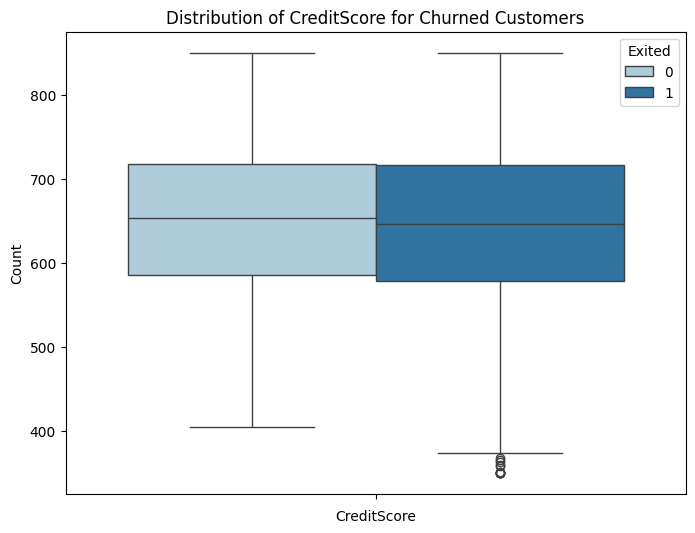

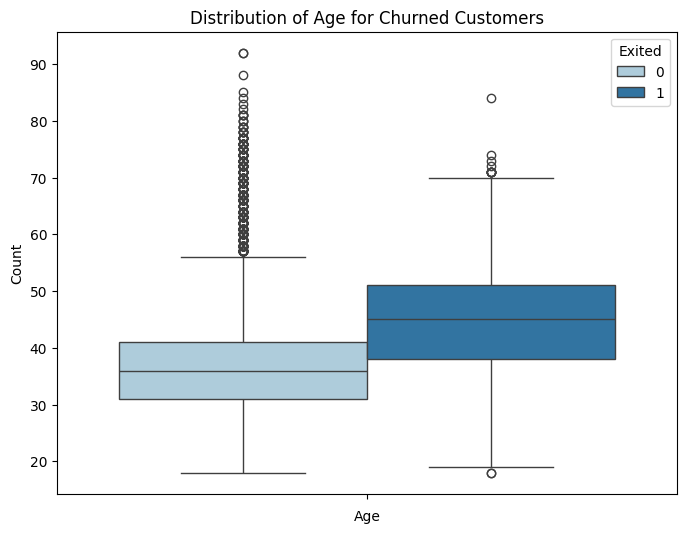

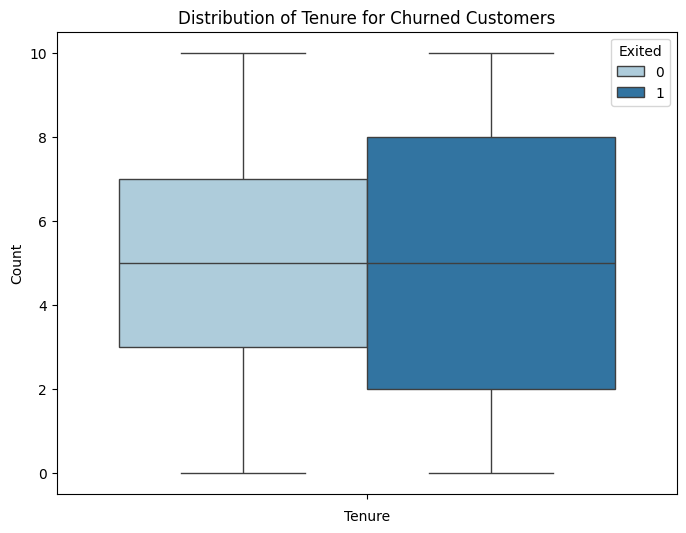

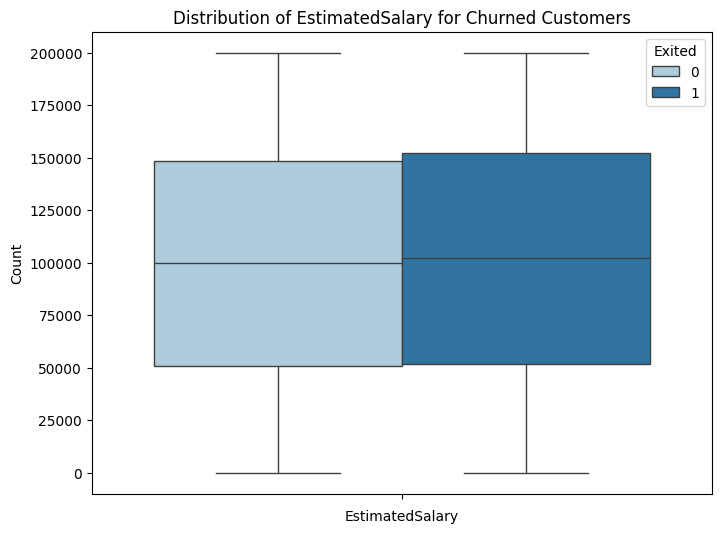

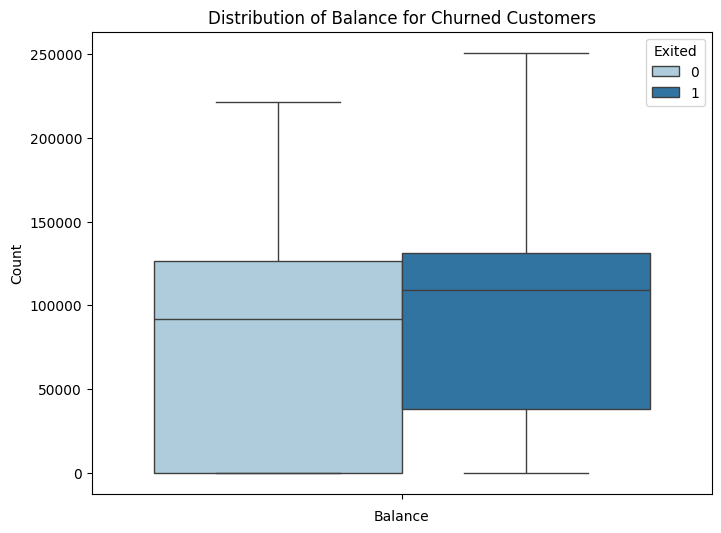

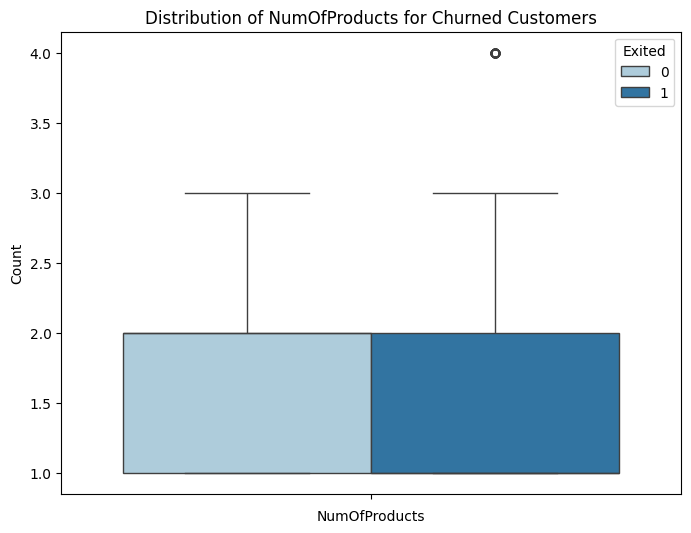

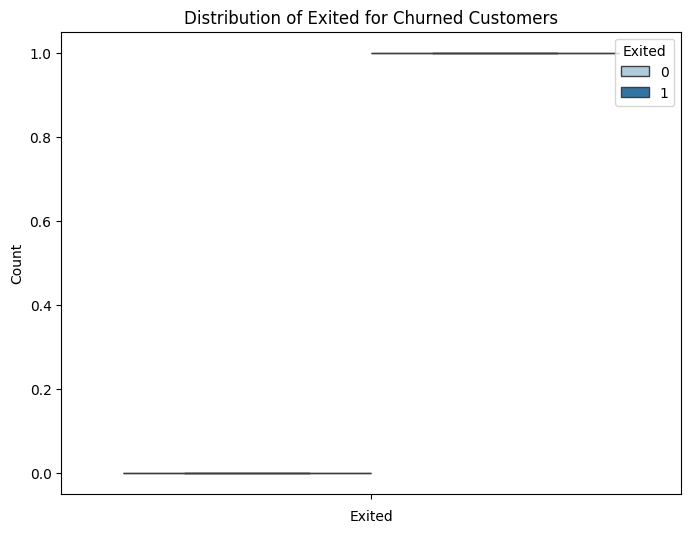

In [15]:
# Generate plots for numeric dtypes, excluding "CustomerId", where "Exited"
for col in bank_data.drop('CustomerId', axis=1).select_dtypes('number'):
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=bank_data, y=col, hue='Exited', palette='Paired')   
        plt.title(f'Distribution of {col} for Churned Customers')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Exited', loc='upper right')

##### 5.8 Churn by Numeric Features (Histogram)

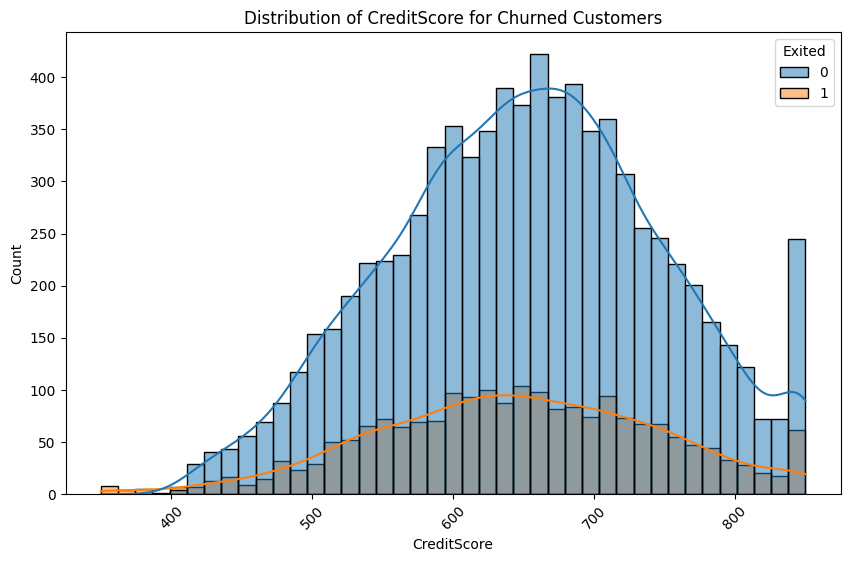

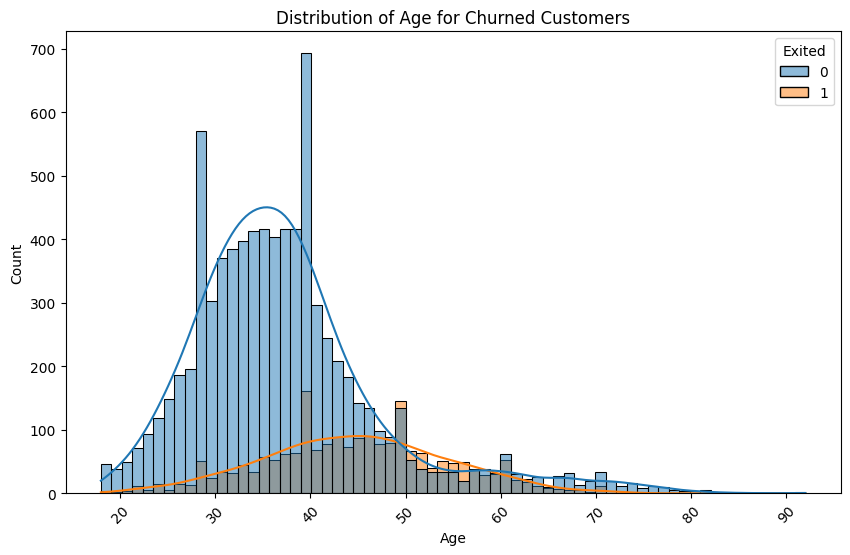

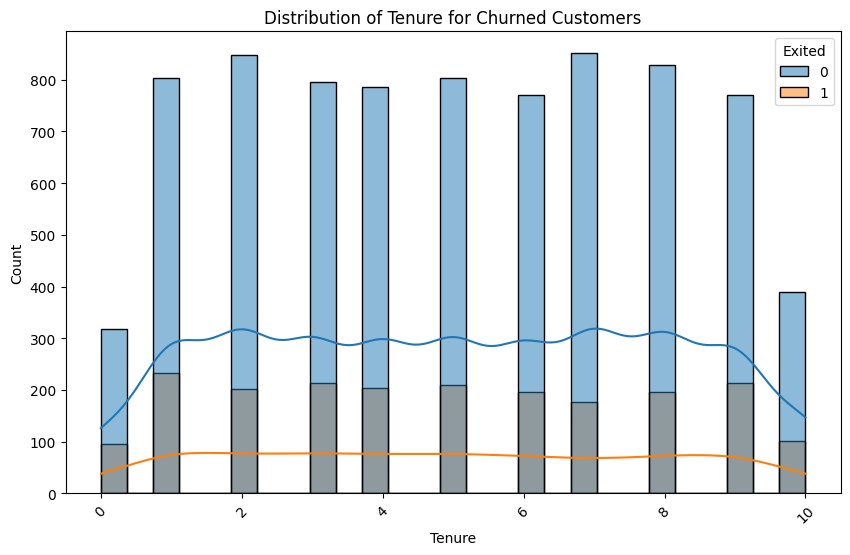

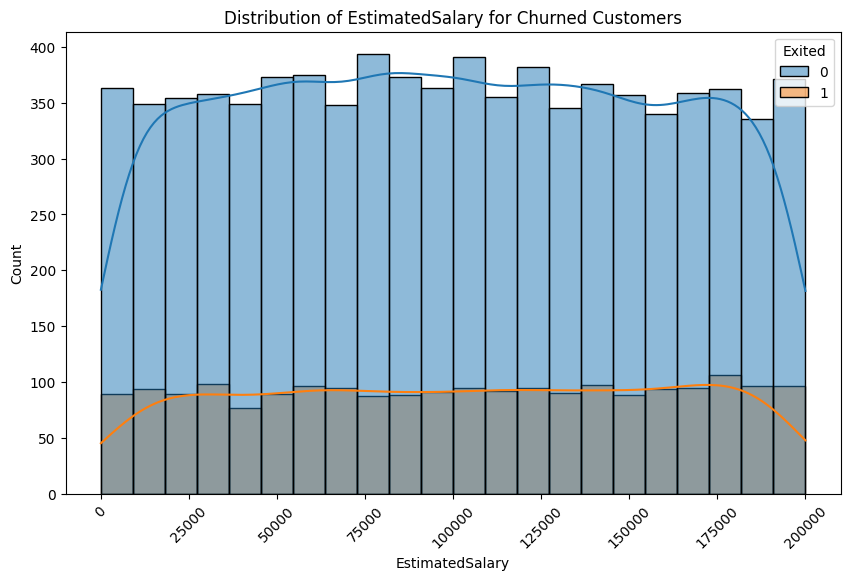

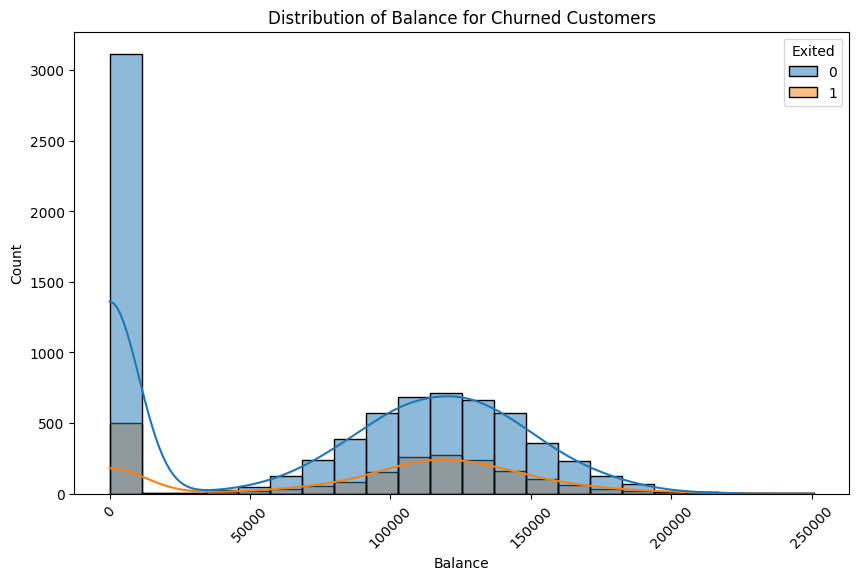

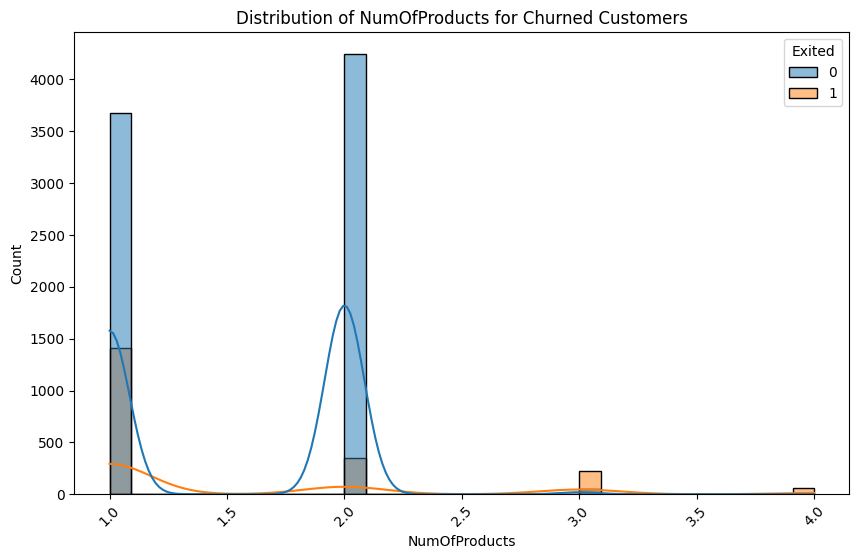

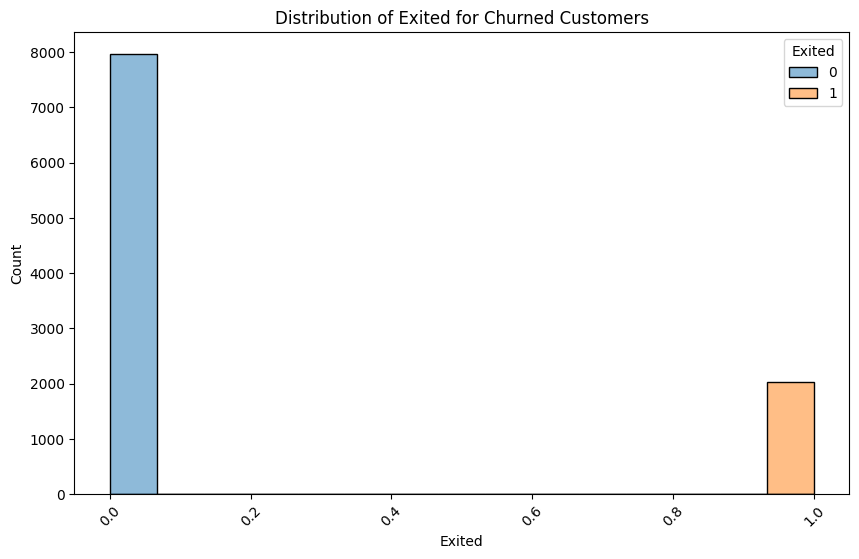

In [16]:
# Generate plots for numeric dtypes, excluding "CustomerId", where "Exited"
for col in bank_data.drop('CustomerId', axis=1).select_dtypes('number'):
        plt.figure(figsize=(10, 6))
        sns.histplot(data=bank_data, x=col, hue='Exited', kde=True)       
        plt.title(f'Distribution of {col} for Churned Customers')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

##### 5.9 Feature Correlation Heatmap

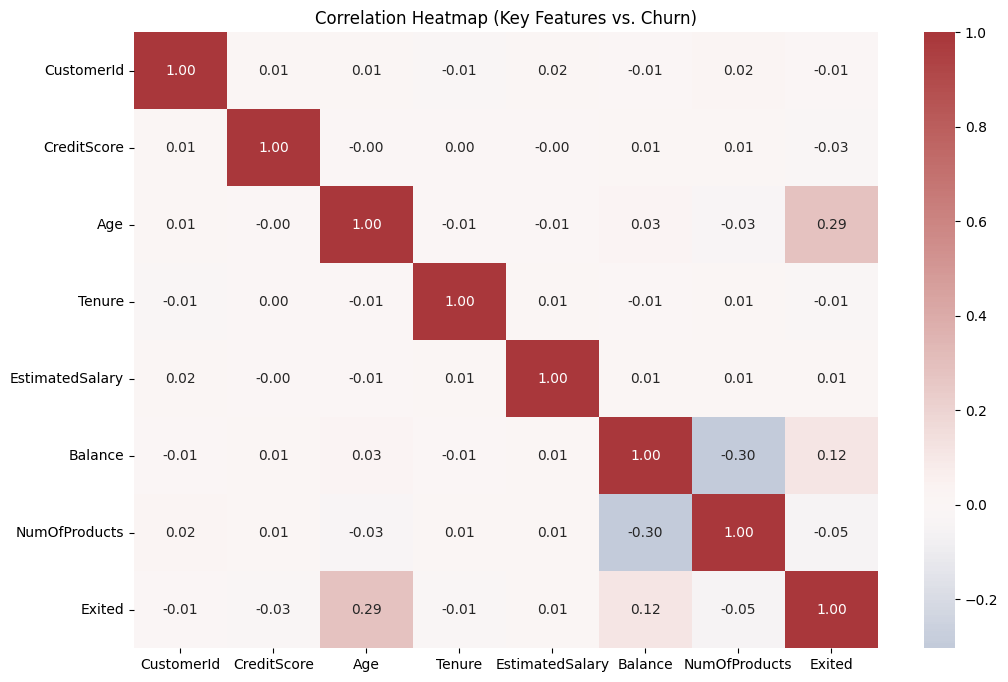

In [17]:
# Calculate correlations
corr = bank_data.corr(numeric_only=True)

# Plot heatmap (focus on churn correlations)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='vlag', center=0, fmt=".2f")
plt.title("Correlation Heatmap (Key Features vs. Churn)")
plt.show()

#### 6. Data Preparation & Feature Engineering

Machine learning models require numeric input. Therefore, I used label encoding for binary categorical variables (like Gender, HasCrCard, IsActiveMember) and one-hot encoding for multi-class variables (like Geography). This transformation allows the models to process these features effectively and prevents them from misinterpreting categorical data as ordinal.

In [18]:
# Convert categorical Yes/No variables to binary
Le = LabelEncoder()

bank_data['Gender'] = Le.fit_transform(bank_data['Gender']) 
bank_data['HasCrCard'] = Le.fit_transform(bank_data['HasCrCard'])
bank_data['IsActiveMember'] = Le.fit_transform(bank_data['IsActiveMember'])
bank_data['Age_Group'] = Le.fit_transform(bank_data['Age_Group'])
bank_data['Credit_Score_Category'] = Le.fit_transform(bank_data['Credit_Score_Category'])

bank_data = pd.get_dummies(bank_data, columns=['Geography'], drop_first=True, dtype=int)

#### 7. Model Preparation

In [19]:
# Drop unnecessary columns and prepare features and target variable
model_features = bank_data.drop(columns=['Surname', 'CustomerId', 'Age_Group', 'Credit_Score_Category'], axis=1) #, 'Age_Group', 'Credit_Score_Category'

x = model_features.drop('Exited', axis=1)
y = bank_data['Exited']

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### 8. Base Model Training & Evaluation

#####  8.1 Logistic Regression

In [20]:
# Create a Logistic Regression model
lr_model = LogisticRegression( random_state=42) 

# Fit the model to the training data
lr_model.fit(x_train, y_train)
# Predict on test data
y_pred_lr = lr_model.predict(x_test)
# Predict probabilities
y_pred_prob_lr = lr_model.predict_proba(x_test)[:, 1]
# Calculate the ROC AUC score for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)
# Calculate the AUC score for Logistic Regression
auc_lr = roc_auc_score(y_test, y_pred_prob_lr)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("\nProbablility Prediction: \n", y_pred_prob_lr[:5])
print("\nROC AUC Score:", auc_lr)

Accuracy: 0.812

Confusion Matrix:
 [[1544   63]
 [ 313   80]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.56      0.20      0.30       393

    accuracy                           0.81      2000
   macro avg       0.70      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


Probablility Prediction: 
 [0.22986467 0.07760942 0.31697681 0.43605634 0.06735771]

ROC AUC Score: 0.7788286298335367


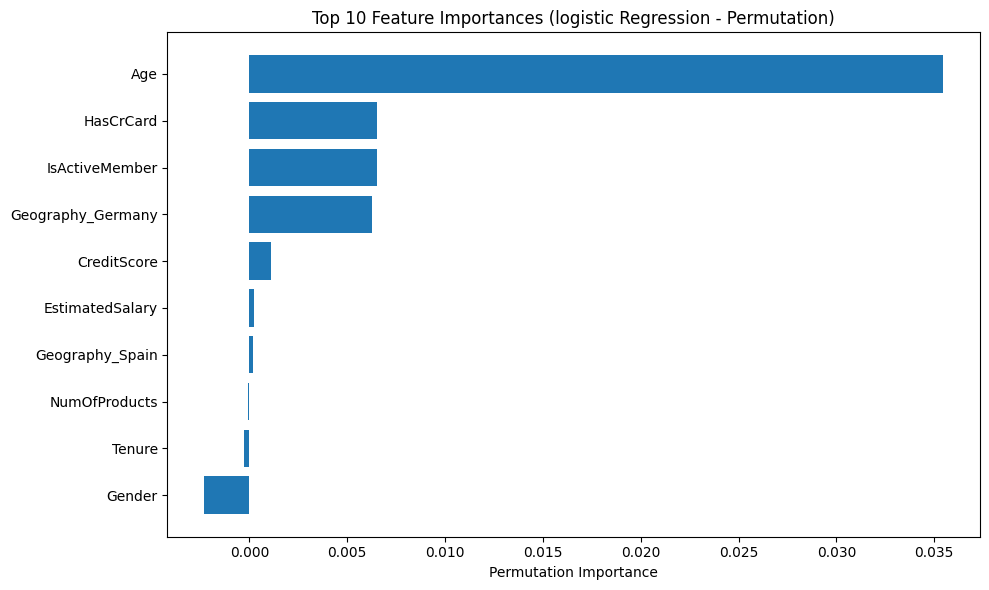

In [21]:
# Permutation Importance for Logistic Regression
result = permutation_importance(lr_model, x_test, y_test, n_repeats=10, random_state=42,  scoring='accuracy')

# Create a DataFrame for Permutation Importance
lr_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(lr_importance['Feature'][:10][::-1], lr_importance['Importance'][:10][::-1])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Feature Importances (logistic Regression - Permutation)')
plt.tight_layout()
plt.show()

##### 8.2 K-Nearest Neighbors (KNN)

In [22]:
# Create a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn_model.fit(x_train, y_train)

# Predict on test data
y_pred_knn = knn_model.predict(x_test)
# predict probabilities for the test set for KNN
y_pred_prob_knn = knn_model.predict_proba(x_test)[:, 1]
# Calculate the ROC AUC score for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_prob_knn)
# Calculate the AUC score for KNN
auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy: 0.836

Confusion Matrix:
 [[1514   93]
 [ 235  158]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1607
           1       0.63      0.40      0.49       393

    accuracy                           0.84      2000
   macro avg       0.75      0.67      0.70      2000
weighted avg       0.82      0.84      0.82      2000



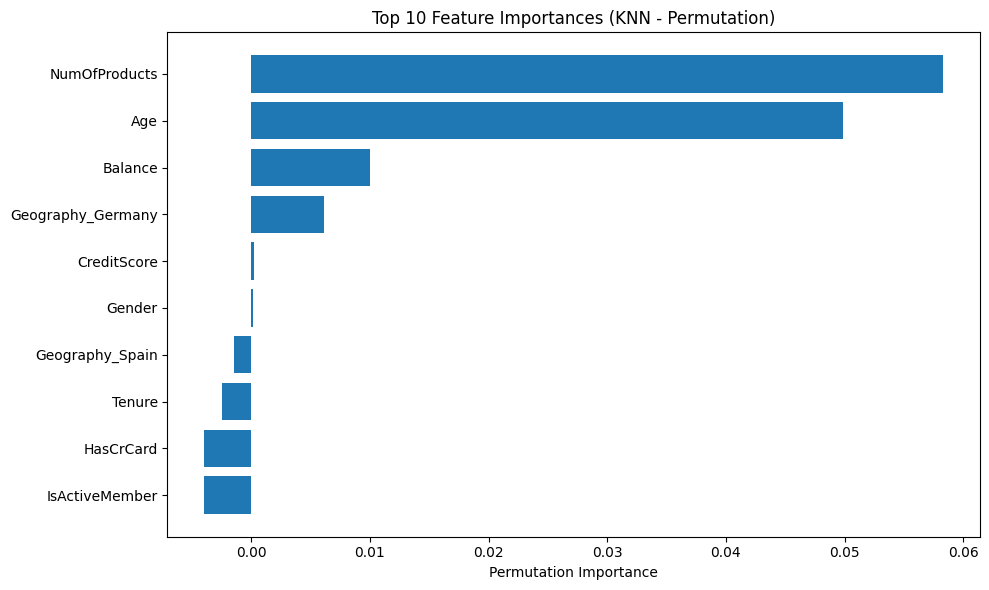

In [23]:
# Compute permutation importance on the test set
result = permutation_importance(knn_model, x_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Create a DataFrame for easy viewing
knn_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(knn_importance['Feature'][:10][::-1], knn_importance['Importance'][:10][::-1])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Feature Importances (KNN - Permutation)')
plt.tight_layout()
plt.show()

##### 8.3 Random Forest Classifier

In [24]:
# Create a Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(x_train, y_train)
# Predict on test data
y_pred_rf = rf_model.predict(x_test)
# Predict probabilities
y_pred_prob_rf = rf_model.predict_proba(x_test)[:, 1]
# Calculate the ROC AUC score for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
# Calculate the AUC score for Random Forest
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)


print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nROC AUC Score:", auc_rf)

Accuracy: 0.8675

Confusion Matrix:
 [[1544   63]
 [ 202  191]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000


ROC AUC Score: 0.8587113313097438


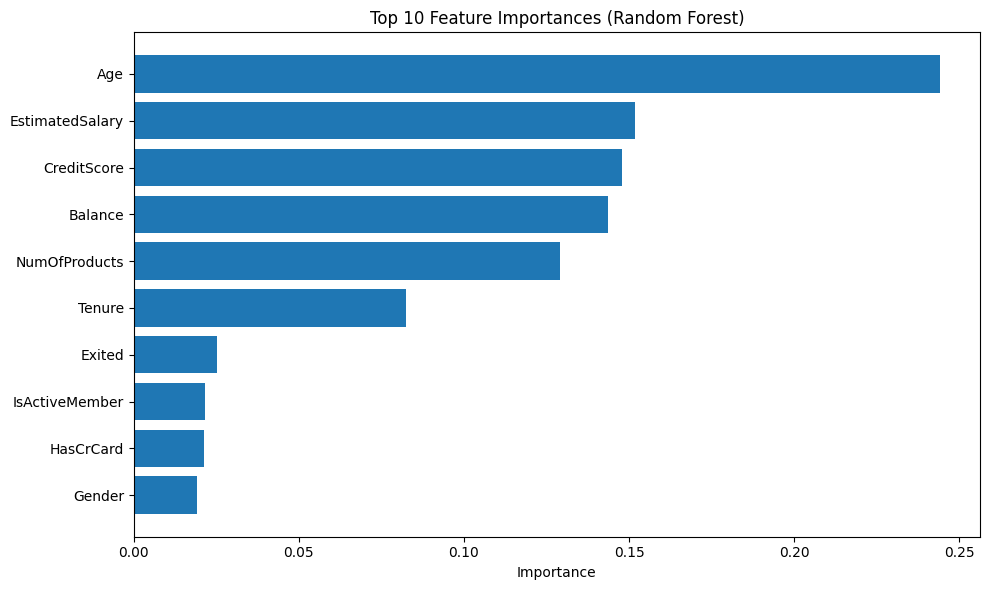

In [25]:
# Feature Importance Random Forest

# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
indicies = np.argsort(importances)[::-1]
feature_names = [model_features.columns[i] for i in indicies]  # Fix here

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances[indicies]})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:10][::-1], feat_imp_df['Importance'][:10][::-1])  # Adjusted to match top 10
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


##### 8.4 Gradient Boosting Classifier

In [26]:
# Create a Gradient Boosting Classifier model
gb_model = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
gb_model.fit(x_train, y_train)

# Predict on test data
y_pred_gb = gb_model.predict(x_test)
# Predict probabilities for the test set for Gradient Boosting
y_pred_prob_gb = gb_model.predict_proba(x_test)[:, 1]
# Calculate the ROC AUC score for Gradient Boosting
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_prob_gb)
# Calculate the AUC score for Gradient Boosting
auc_gb = roc_auc_score(y_test, y_pred_prob_gb)

print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("\nROC AUC Score:", auc_gb)

Accuracy: 0.8665

Confusion Matrix:
 [[1542   65]
 [ 202  191]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.86      2000


ROC AUC Score: 0.8725122753348502


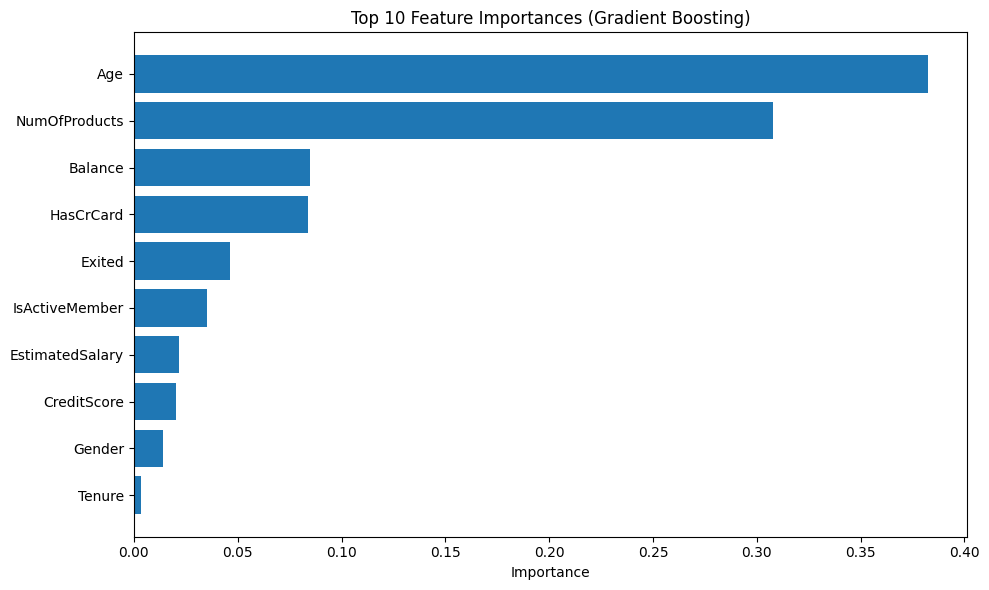

In [27]:
# Feature Importance Gradient Boosting
importances = gb_model.feature_importances_
indicies = np.argsort(importances)[::-1]
feature_names = [model_features.columns[i] for i in indicies]  # Fix here

# Combine into a DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances[indicies]})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:10][::-1], feat_imp_df['Importance'][:10][::-1])  # Adjusted to match top 10
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.tight_layout()
plt.show()

##### 8.5 Precision Recall Curve  

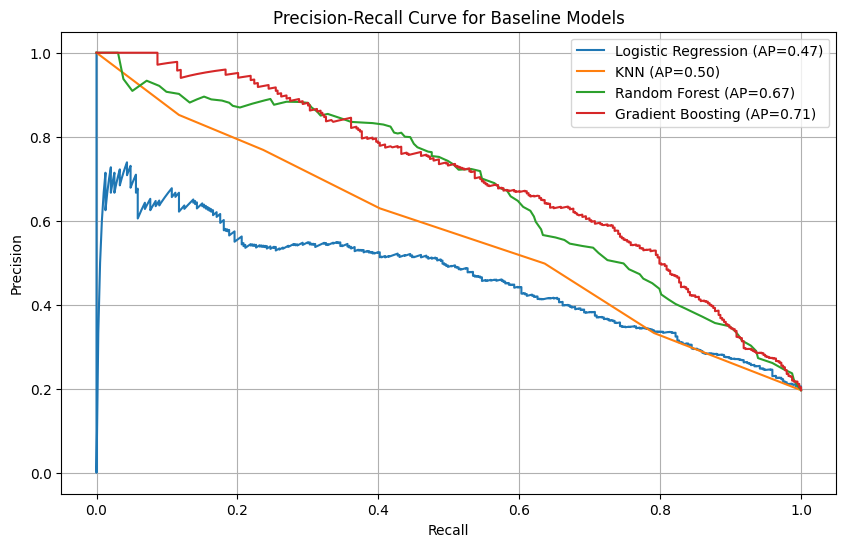

In [28]:
# Plot Precision-Recall Curve for Baseline Model

models = {
    'Logistic Regression': lr_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

plt.figure(figsize=(10, 6))

for model_name, model in models.items():
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    ap = average_precision_score(y_test, y_pred_prob)
    plt.plot(recall, precision, label=f'{model_name} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Baseline Models')
plt.legend()
plt.grid()
plt.show()

#### 9. Feature Engineering

##### 9.1 Add Aditional Features 

In [29]:
# Add new features 
model_features['BalanceSalaryRatio'] = model_features['Balance'] / model_features['EstimatedSalary']   # Avoid division by zero
model_features['IsHighBalance'] = (model_features['Balance'] > 100000).astype(int)
model_features['BalanceZero'] = (model_features['Balance'] == 0).astype(int)
model_features['IsHighSalary'] = (model_features['EstimatedSalary'] > 100000).astype(int)
model_features['ProductUsage'] = model_features['IsActiveMember'] * model_features['NumOfProducts'] 


# Create features for Germany Customers
model_features['Germany_X_Balance'] = model_features['Balance'] * model_features['Geography_Germany']
model_features['Germany_X_EstimatedSalary'] = model_features['EstimatedSalary'] * model_features['Geography_Germany']
model_features['IsGermanAndLowCreditScore'] = ((model_features['Geography_Germany'] == 1) & (model_features['CreditScore'] < 600)).astype(int)
model_features['IsGermanWithoutCrCard'] = ((model_features['Geography_Germany'] == 1) & (model_features['HasCrCard'] == 0)).astype(int)
model_features['IsGermanAndInactive'] = ((model_features['Geography_Germany'] == 1) & (model_features['IsActiveMember'] == 0)).astype(int)

##### 9.2 Retrain Model

In [30]:
# Retrain the model with additional features
x = model_features.drop(columns=['Exited'], axis=1)
y = model_features['Exited']

# Retrain test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fill missing values (example: fill with column mean)
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())


#### 10. Hyperparameter Tuning

##### 10.1.a Random Forest Hyperparameter

In [31]:
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.5], # 0.5 means 50% of features
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Create a StratifiedKFold object for cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=50,  # Adjust number of iterations based on time/resources
    cv=cv_stratified,
    verbose=2, # Set to 2 for more details
    random_state=42,
    n_jobs=-1,  # Use all available cores
    scoring='f1_macro' # Or another relevant metric for churn
)

# Fit the RandomizedSearchCV
print("Starting RandomizedSearchCV...")
random_search_rf.fit(x_train, y_train)

# Get the best parameters and score
print("Best Random Forest parameters found: ", random_search_rf.best_params_)
print("Best Random Forest F1 Macro (CV): ", random_search_rf.best_score_)

# Use the best estimator to make predictions
best_rf_model = random_search_rf.best_estimator_

# Predict on the test set
y_pred_test_rf = best_rf_model.predict(x_test)
print(classification_report(y_test, y_pred_test_rf))


Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest parameters found:  {'class_weight': 'balanced_subsample', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 340}
Best Random Forest F1 Macro (CV):  0.7670965005886211
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1607
           1       0.63      0.61      0.62       393

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.85      0.85      0.85      2000



##### 10.1.b Random Forest Threshold Tuning

In [32]:
print("\n--- Starting Threshold Tuning for Best Random Forest Model ---")

# Predict probabilities for the positive class (Churn = 1)
y_pred_proba_rf = best_rf_model.predict_proba(x_test)[:, 1]

# Iterate Through Different Thresholds & Calculate Metrics
thresholds_rf = np.arange(0.1, 1.0, 0.05) # Test thresholds from 0.1 to 0.95
results_rf = []

for thresh in thresholds_rf:
    # Apply threshold to probabilities to create new predictions
    y_pred_tuned_rf = (y_pred_proba_rf >= thresh).astype(int)

    # Calculate metrics for the 'Churn' class (positive label = 1)
    # Handle cases where no positive predictions are made (to avoid zero division warnings for precision/f1)
    precision = precision_score(y_test, y_pred_tuned_rf, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred_tuned_rf, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_tuned_rf, pos_label=1, zero_division=0)

    results_rf.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to a DataFrame for easy viewing
results_rf_df = pd.DataFrame(results_rf)

print("\nPrecision, Recall, and F1-Score at Different Thresholds (Random Forest):")
print(results_rf_df)




--- Starting Threshold Tuning for Best Random Forest Model ---

Precision, Recall, and F1-Score at Different Thresholds (Random Forest):
    Threshold  Precision    Recall  F1-Score
0        0.10   0.267271  0.974555  0.419496
1        0.15   0.306344  0.933842  0.461345
2        0.20   0.347956  0.888041  0.500000
3        0.25   0.391355  0.852417  0.536429
4        0.30   0.441541  0.816794  0.573214
5        0.35   0.495130  0.776081  0.604559
6        0.40   0.543860  0.709924  0.615894
7        0.45   0.571106  0.643766  0.605263
8        0.50   0.630890  0.613232  0.621935
9        0.55   0.669725  0.557252  0.608333
10       0.60   0.709790  0.516539  0.597938
11       0.65   0.732510  0.452926  0.559748
12       0.70   0.785000  0.399491  0.529511
13       0.75   0.823899  0.333333  0.474638
14       0.80   0.870690  0.256997  0.396857
15       0.85   0.917808  0.170483  0.287554
16       0.90   0.941176  0.081425  0.149883
17       0.95   1.000000  0.015267  0.030075


##### 10.1.c Random Forest: Precision, Recall, and F1-Score vs. Threshold


Threshold for Best F1-Score (Churn Class): 0.50
At this threshold - Precision: 0.63, Recall: 0.61, F1: 0.62


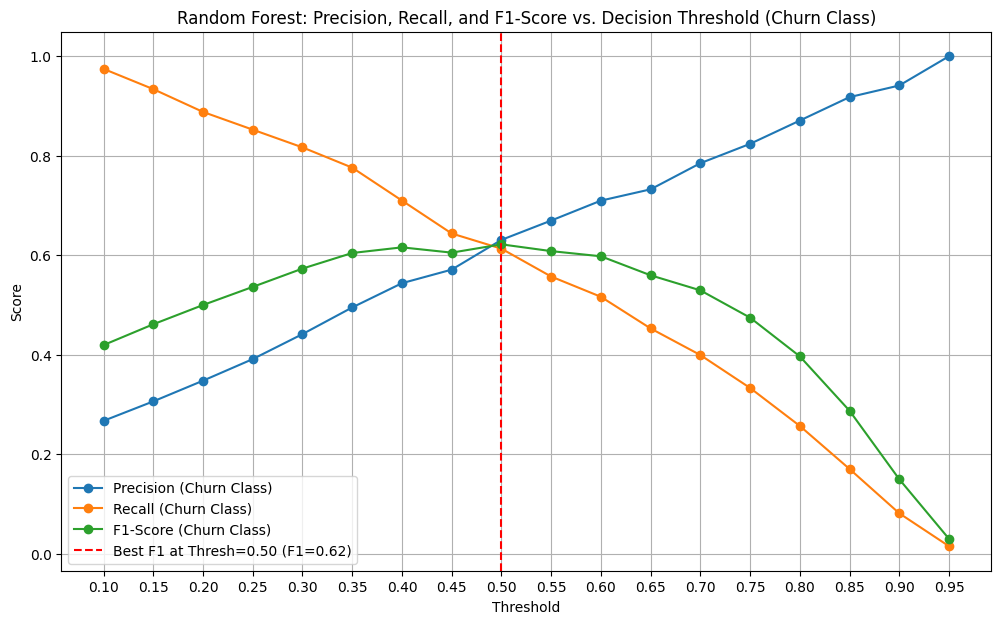

In [33]:
# Visualize the Trade-off for Random Forest
plt.figure(figsize=(12, 7))
plt.plot(results_rf_df['Threshold'], results_rf_df['Precision'], label='Precision (Churn Class)', marker='o')
plt.plot(results_rf_df['Threshold'], results_rf_df['Recall'], label='Recall (Churn Class)', marker='o')
plt.plot(results_rf_df['Threshold'], results_rf_df['F1-Score'], label='F1-Score (Churn Class)', marker='o')

# Find and highlight the threshold that maximizes F1-Score for the churn class
if not results_rf_df.empty and results_rf_df['F1-Score'].max() > 0:
    best_f1_row_rf = results_rf_df.loc[results_rf_df['F1-Score'].idxmax()]
    plt.axvline(x=best_f1_row_rf['Threshold'], color='r', linestyle='--', 
                label=f"Best F1 at Thresh={best_f1_row_rf['Threshold']:.2f} (F1={best_f1_row_rf['F1-Score']:.2f})")
    print(f"\nThreshold for Best F1-Score (Churn Class): {best_f1_row_rf['Threshold']:.2f}")
    print(f"At this threshold - Precision: {best_f1_row_rf['Precision']:.2f}, Recall: {best_f1_row_rf['Recall']:.2f}, F1: {best_f1_row_rf['F1-Score']:.2f}")


plt.title('Random Forest: Precision, Recall, and F1-Score vs. Decision Threshold (Churn Class)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0.1, 1.0, 0.05)) # More granular x-axis ticks
plt.show()

##### 10.2.a Gradient Boosting Hyperparameter 

In [34]:
# Create a Pipeline with SMOTE and the Gradient Boosting Model
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('gb_model', GradientBoostingClassifier(random_state=42))
])

# Define the parameter distribution for Gradient Boosting
param_dist_gb = {
    'gb_model__n_estimators': randint(100, 500),
    'gb_model__max_depth': randint(3, 8),
    'gb_model__min_samples_split': randint(2, 20),
    'gb_model__min_samples_leaf': randint(1, 10),
    'gb_model__learning_rate': uniform(0.01, 0.2),
    'gb_model__subsample': uniform(0.5, 0.5), # Between 0.5 and 1.0
}

# Set Up and Run RandomizedSearchCV
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_gb = RandomizedSearchCV(
    estimator=smote_pipeline,
    param_distributions=param_dist_gb,
    n_iter=50,  
    cv=cv_stratified,
    verbose=2,  
    random_state=42,
    n_jobs=-1, 
    scoring='f1_macro'  
)

# Fit the search to your data
print("Starting RandomizedSearchCV for Gradient Boosting...")
random_search_gb.fit(x_train, y_train)

# Extract and Use the Results
print("Best Gradient Boosting parameters found: ", random_search_gb.best_params_)
print("Best Gradient Boosting F1 Macro (CV): ", random_search_gb.best_score_)

# Use the best estimator to make predictions
best_gb_model = random_search_gb.best_estimator_
# Predict on the test set
y_pred_test_gb = best_gb_model.predict(x_test)

print(classification_report(y_test, y_pred_test_gb))

Starting RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Gradient Boosting parameters found:  {'gb_model__learning_rate': 0.051783743523072044, 'gb_model__max_depth': 4, 'gb_model__min_samples_leaf': 2, 'gb_model__min_samples_split': 18, 'gb_model__n_estimators': 203, 'gb_model__subsample': 0.848507870497634}
Best Gradient Boosting F1 Macro (CV):  0.7496196256245667
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1607
           1       0.55      0.72      0.62       393

    accuracy                           0.83      2000
   macro avg       0.74      0.79      0.75      2000
weighted avg       0.85      0.83      0.84      2000



##### 10.2.b Gradient Boosting Threshhold Tuning

In [35]:
print("\n--- Starting Threshold Tuning for Best Gradient Boost Model ---")

# Get the probabilities for the positive class (Churn)
y_pred_proba = best_gb_model.predict_proba(x_test)[:, 1]

# Create a range of thresholds to test
thresholds = np.arange(0.1, 1.0, 0.05)
results = []

for thresh in thresholds:
    # Apply threshold to probabilities to create new predictions
    y_pred_tuned = (y_pred_proba >= thresh).astype(int)

  # Calculate metrics for the 'Churn' class (positive label = 1)
    precision = precision_score(y_test, y_pred_tuned, pos_label=1)
    recall = recall_score(y_test, y_pred_tuned, pos_label=1)
    f1 = f1_score(y_test, y_pred_tuned, pos_label=1)

    results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

print("\n Precision, Recall, and F1-Score at Different Thresholds:")
print(results_df)


--- Starting Threshold Tuning for Best Gradient Boost Model ---

 Precision, Recall, and F1-Score at Different Thresholds:
    Threshold  Precision    Recall  F1-Score
0        0.10   0.285171  0.954198  0.439110
1        0.15   0.327854  0.913486  0.482527
2        0.20   0.367756  0.888041  0.520119
3        0.25   0.402861  0.860051  0.548701
4        0.30   0.435897  0.821883  0.569665
5        0.35   0.467262  0.798982  0.589671
6        0.40   0.490260  0.768448  0.598612
7        0.45   0.516934  0.737913  0.607966
8        0.50   0.546693  0.715013  0.619625
9        0.55   0.577922  0.679389  0.624561
10       0.60   0.594272  0.633588  0.613300
11       0.65   0.622995  0.592875  0.607562
12       0.70   0.640625  0.521628  0.575035
13       0.75   0.665455  0.465649  0.547904
14       0.80   0.705357  0.402036  0.512156
15       0.85   0.791411  0.328244  0.464029
16       0.90   0.904762  0.241730  0.381526
17       0.95   0.920000  0.117048  0.207675


##### 10.1.c Gradient Boost: Precision, Recall, and F1-Score vs. Threshold

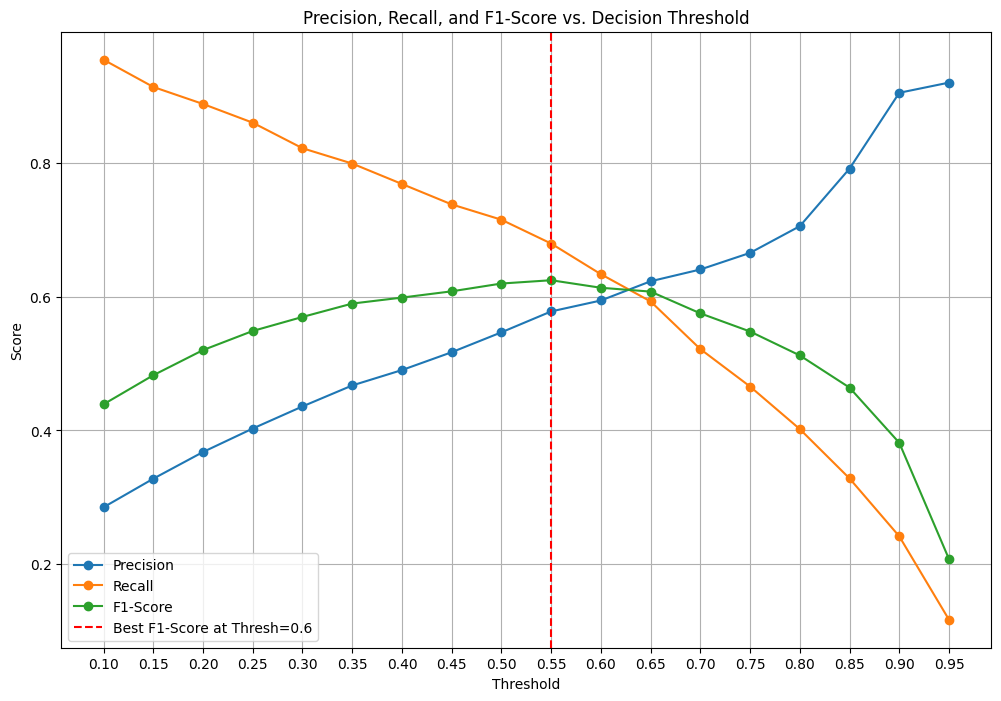

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='o')

# Find the threshold that maximizes F1-Score to highlight it
best_f1_row = results_df.loc[results_df['F1-Score'].idxmax()]
plt.axvline(x=best_f1_row['Threshold'], color='r', linestyle='--', label=f"Best F1-Score at Thresh={best_f1_row['Threshold']:.1f}")

plt.title('Precision, Recall, and F1-Score vs. Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0.1, 1.0, 0.05))  # More granular x-axis ticks
plt.show()

#### 11. Champion Model

In [37]:
final_threshold = 0.45

# Apply the threshold to get final predictions
final_predictions = (y_pred_proba >= final_threshold).astype(int)

# Create a DataFrame to summarize the results
results_summary = pd.DataFrame({
    'Actual_Churn': y_test,
    'Churn_Probability': y_pred_proba,
    'Predicted_Churn_at_0.45': final_predictions
})

# Display customers flagged as at-risk
at_risk_customers = results_summary[results_summary['Predicted_Churn_at_0.45'] == 1]
print("Customers identified as at-risk with a 0.45 threshold:")
print(at_risk_customers.head(10))

Customers identified as at-risk with a 0.45 threshold:
      Actual_Churn  Churn_Probability  Predicted_Churn_at_0.45
6364             0           0.642734                        1
440              0           0.531441                        1
2751             1           0.961164                        1
7488             1           0.983626                        1
5273             1           0.817938                        1
5654             0           0.760986                        1
9921             1           0.543848                        1
3338             1           0.779249                        1
5590             1           0.791615                        1
36               1           0.878995                        1


In [38]:
final_model = best_gb_model.named_steps['gb_model']
feature_names = x_train.columns 

# Get feature importances
importances = final_model.feature_importances_
y_pred_final = final_model.predict(x_test)

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Final Feature Importances from Champion Model ---")
print(feature_importance_df.head(10))
print("\n\n--- Final Model Performance ---")
print( classification_report(y_test, y_pred_final))


--- Final Feature Importances from Champion Model ---
               Feature  Importance
2                  Age    0.327301
6        NumOfProducts    0.144565
7            HasCrCard    0.105428
8       IsActiveMember    0.089804
1               Gender    0.089225
16   Germany_X_Balance    0.054208
15        ProductUsage    0.043377
5              Balance    0.032267
11  BalanceSalaryRatio    0.028209
4      EstimatedSalary    0.019997


--- Final Model Performance ---
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1607
           1       0.55      0.72      0.62       393

    accuracy                           0.83      2000
   macro avg       0.74      0.79      0.75      2000
weighted avg       0.85      0.83      0.84      2000




--- Final Feature Importances from Champion Model ---
               Feature  Importance
2                  Age    0.327301
6        NumOfProducts    0.144565
7            HasCrCard    0.105428
8       IsActiveMember    0.089804
1               Gender    0.089225
16   Germany_X_Balance    0.054208
15        ProductUsage    0.043377
5              Balance    0.032267
11  BalanceSalaryRatio    0.028209
4      EstimatedSalary    0.019997


--- Final Model Performance ---
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1607
           1       0.55      0.72      0.62       393

    accuracy                           0.83      2000
   macro avg       0.74      0.79      0.75      2000
weighted avg       0.85      0.83      0.84      2000



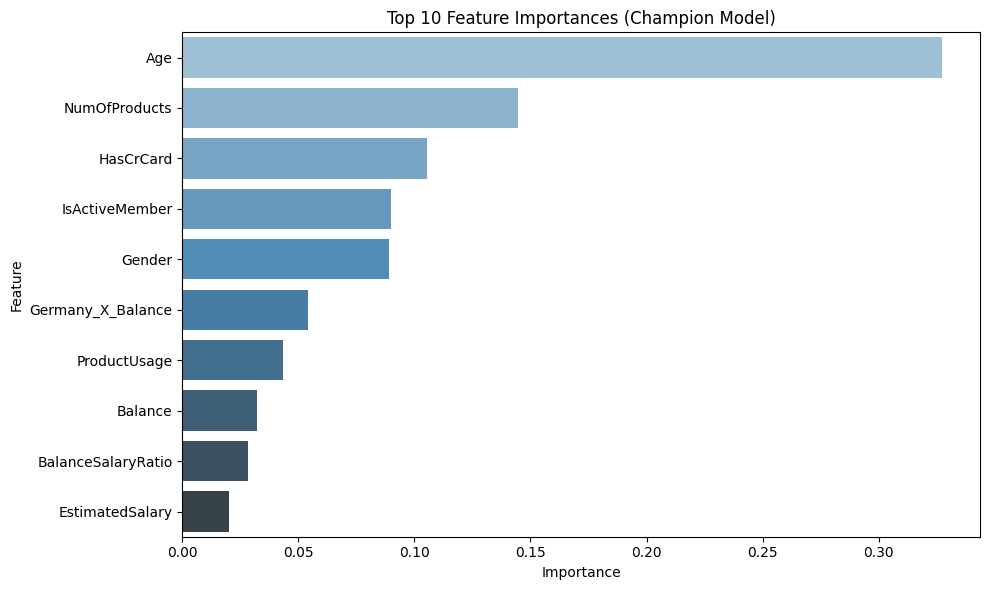

In [41]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Final Feature Importances from Champion Model ---")
print(feature_importance_df.head(10))
print("\n\n--- Final Model Performance ---")
print(classification_report(y_test, y_pred_final))

# Visualize the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(10),
    x='Importance',
    hue='Feature',
    y='Feature',
    palette='Blues_d'
)
plt.title('Top 10 Feature Importances (Champion Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()